In [1]:
import pandas as pd
import numpy as np
import glob
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

root_dir = '/oak/stanford/groups/horence/rob/isoform_localizations/'

sys.path.append(os.path.join(root_dir,'scripts'))
import spatial_utils
import plot_utils

In [2]:
df = pd.read_csv('../processed_data/min_periph_dists.csv')
df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
1,-4183.0010,1688.5905,0.0,Acta2,1,281878279612082858224382179441472205807,mouse1sample2,1.891179
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409


In [3]:
cells = pd.read_csv('../processed_data/q90_cells.csv')
cells.head()

,cell_id,boundaryX,boundaryY,slice_id,sample
0,102513782275574352391549636869222584212,"2097.1362953431903, 2097.1362953431903, 2097.1...","2346.248493306339, 2345.705993324518, 2345.163...",mouse2_slice10,mouse2sample2
1,198259986845326386185083518576166673028,"2106.141795041412, 2106.141795041412, 2106.141...","2328.9969938844442, 2328.4544939026237, 2327.9...",mouse2_slice10,mouse2sample2
2,202633430165103308157026102881717708611,"2058.727296630293, 2058.727296630293, 2058.727...","2228.8514972403646, 2228.308997258544, 2227.76...",mouse2_slice10,mouse2sample2
3,202866835269971649617924499544299592196,"2055.3637967430054, 2055.3637967430054, 2055.2...","2248.4899965822697, 2247.947496600449, 2247.51...",mouse2_slice10,mouse2sample2
4,21014129563353280159906900457364829387,"2096.1597953759133, 2096.1597953759133, 2096.0...","2310.4434945061803, 2309.9009945243597, 2309.4...",mouse2_slice10,mouse2sample2


In [4]:
df['cell_id'].unique().size

237879

In [5]:
cells['cell_id'].unique().size

23751

In [6]:
q90_df = df[df['cell_id'].isin(cells['cell_id'].unique())]
q90_df.shape

(22663571, 8)

In [10]:
import time


start = time.time()
def permutations(sub_df, its=100):
    def gene_perm_median_scores(sub_df):
        for cell_id,cell_g in sub_df.groupby('cell_id'):
            num_spots = cell_g.shape[0]
            cell_g['norm_ranks'] = np.random.permutation(np.arange(num_spots))/num_spots
            gene_medians = cell_g.groupby('target_molecule_name')['norm_ranks'].median()

            yield gene_medians.rename(cell_id)

    for i in range(its):
        single_perm_all_cells = pd.concat(gene_perm_median_scores(sub_df),axis=1)
        single_perm_medians = single_perm_all_cells.median(axis=1)
        yield single_perm_medians.rename(i)


x = pd.concat(permutations(q90_df, its=1),axis=1)
print(time.time()-start)
x.head()

97.23217177391052


,0
1700022I11Rik,0.490471
Acta2,0.500516
Adam2,0.503973
Adamts4,0.493945
Adra1b,0.499247


# Using multiprocessing pools

In [54]:
num_sub_cells = 1000
sub_df_q90 = q90_df[q90_df['cell_id'].isin(q90_df.drop_duplicates('cell_id').head(num_sub_cells)['cell_id'].values)]

In [ ]:
161 seconds for 1000 cells with 50 permutations

In [106]:
sub_df_q90.pivot_table(
    index='cell_id',
    columns='target_molecule_name',
    values='cell_spot_count',
)

target_molecule_name,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Unc13c,Unc5b,Unc5d,Ust,Vipr2,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b
cell_id,,,,,,,,,,,,,,,,,,,,,
100130158641614214322940227367512855281,NaN,812.0,NaN,NaN,812.0,NaN,812.0,NaN,812.0,812.0,...,812.0,NaN,812.0,812.0,NaN,NaN,812.0,812.0,812.0,NaN
100168912407247156362856978288134206436,NaN,943.0,NaN,NaN,943.0,NaN,NaN,NaN,NaN,943.0,...,NaN,943.0,943.0,NaN,NaN,NaN,943.0,943.0,NaN,943.0
100305580936119098950035827392909243549,NaN,961.0,NaN,NaN,NaN,NaN,NaN,NaN,961.0,961.0,...,NaN,961.0,961.0,961.0,NaN,NaN,NaN,961.0,961.0,NaN
100642081058886603827101492098833873059,NaN,NaN,NaN,880.0,880.0,880.0,NaN,NaN,880.0,NaN,...,NaN,NaN,880.0,NaN,NaN,880.0,NaN,880.0,880.0,NaN
100648607726260164904770499835137605603,NaN,NaN,NaN,NaN,755.0,NaN,755.0,755.0,755.0,755.0,...,NaN,NaN,755.0,755.0,NaN,NaN,755.0,755.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99039148500152329390703257129832788188,969.0,NaN,NaN,969.0,969.0,NaN,NaN,NaN,969.0,NaN,...,NaN,969.0,969.0,969.0,NaN,NaN,969.0,969.0,969.0,969.0
99071568106041378886737103325776414290,NaN,NaN,NaN,1109.0,1109.0,NaN,1109.0,NaN,NaN,NaN,...,1109.0,1109.0,1109.0,1109.0,NaN,NaN,NaN,1109.0,1109.0,NaN
9920606402221726943382263684886864923,NaN,834.0,NaN,NaN,834.0,NaN,834.0,NaN,834.0,834.0,...,834.0,NaN,834.0,NaN,NaN,NaN,834.0,834.0,NaN,NaN


In [111]:
sub_df_q90.groupby('cell_id').size()

cell_id
100130158641614214322940227367512855281     812
100168912407247156362856978288134206436     943
100305580936119098950035827392909243549     961
100642081058886603827101492098833873059     880
100648607726260164904770499835137605603     755
                                           ... 
99039148500152329390703257129832788188      969
99071568106041378886737103325776414290     1109
9920606402221726943382263684886864923       834
99253164870499320914020299741295758774      774
99264522271964554826815586820236383352     1170
Length: 1000, dtype: int64

In [137]:
sub_df_q90 = q90_df[q90_df['cell_id'].isin(q90_df.drop_duplicates('cell_id').head(1000)['cell_id'].values)]
sub_df_q90

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409
5,-4270.8410,1726.0154,0.0,Acta2,1,29559620824861669263446897425219499530,mouse1sample2,3.183747
...,...,...,...,...,...,...,...,...
10241973,3430.1338,2257.4424,1.5,Ntng2,1,153332918144280571199660529752932491675,mouse1sample2,3.826231
10241975,3335.5557,2281.0955,1.5,Ntng2,1,219536569797940942576392750520554138291,mouse1sample2,0.182023
10241978,3359.9724,2293.0342,1.5,Ntng2,1,128042774206891212695656210265236211628,mouse1sample2,0.899791
10241979,3353.8635,2299.7566,1.5,Ntng2,1,128042774206891212695656210265236211628,mouse1sample2,4.369752


In [138]:
sub_df_q90['cell_id'].unique().size

1000

In [142]:
x

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Acta2,0.453656,0.457802,0.432845,0.454989,0.442437,0.441729,0.454170,0.447626,0.440707,0.440150,...,0.445066,0.436585,0.452830,0.451775,0.431384,0.442746,0.453654,0.449900,0.455090,0.449771
Adam2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ano4,0.464724,0.445902,0.436400,0.454677,0.459232,0.457970,0.439667,0.433133,0.436733,0.451182,...,0.461126,0.440218,0.445771,0.439181,0.443765,0.453720,0.449975,0.451398,0.460865,0.449408
Bcl11b,0.457554,0.461076,0.473111,0.460087,0.462984,0.471334,0.462517,0.452351,0.454972,0.466561,...,0.468539,0.457658,0.468476,0.453991,0.464403,0.468384,0.452767,0.462058,0.458170,0.468985
Bdnf,0.306899,0.316421,0.300021,0.296723,0.301096,0.311044,0.296919,0.324637,0.306545,0.324337,...,0.280673,0.313498,0.281418,0.275240,0.312669,0.312923,0.279796,0.296942,0.281614,0.305971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pld5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pde11a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5031425F14Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mrgprx2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [141]:
def matrix_approach(test_df):

    genes = test_df['target_molecule_name'].unique()
    cells = test_df['cell_id'].unique()

    cell_spot_counts = test_df.groupby('cell_id').size()
    cell_gene_spot_counts = test_df.groupby(['cell_id','target_molecule_name']).size()
    
    num_genes = genes.size
    num_cells = cells.size
    num_its = 1000

    ret_df = np.zeros((num_genes, num_cells, num_its))
    
    for i,gene in enumerate(genes):
        for j,cell in enumerate(cells):
            if gene not in cell_gene_spot_counts[cell]:
                continue
            

            rand_ranks = np.random.choice(
                cell_spot_counts[cell],
                (num_its, cell_gene_spot_counts[cell][gene])
            )/cell_spot_counts[cell]
            
            ret_df[i,j,:] = np.median(rand_ranks, axis=1)
            
    gene_it_meds = pd.DataFrame(np.median(ret_df,axis=1))
    gene_it_meds.index = genes
    
    return gene_it_meds

start = time.time()
x = matrix_approach(q90_df)
print(time.time()-start)

x

KeyboardInterrupt: 

60 seconds to run 100 cells for 100 iterations all genes

203 seconds to run 1000 cells for 100 iterations all genes

232 seconds to run 1000 cells for 1000 iterations all genes

??? seconds to run all cells for 1000 iterations all genes (which is all I'd need)

In [96]:
num_cell_spots

100

In [99]:
num_cell_spots = np.array([50, 100])
num_its = 10
num_gene_spots = np.array([2, 8])

np.median(np.random.choice(num_cell_spots, size=(num_its,num_gene_spots))/num_cell_spots, axis=1)

/home/users/rbierman/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: setting an array element with a sequence.

In [83]:
x[['gene_spot_count','cell_spot_count']].apply(
    lambda r: np.random.choice(r['cell_spot_count'], r['gene_spot_count']),
    axis = 1,
)

0                                                     [323]
1                                           [676, 599, 705]
2                                                     [266]
3         [30, 735, 118, 497, 284, 275, 225, 423, 62, 80...
4                                                     [525]
                                ...                        
119237                                           [217, 114]
119238    [904, 506, 33, 516, 779, 1056, 57, 235, 913, 4...
119239                        [90, 584, 918, 986, 924, 445]
119240            [299, 358, 100, 1120, 166, 776, 388, 382]
119241    [257, 768, 402, 114, 680, 129, 264, 131, 790, ...
Length: 119242, dtype: object

In [73]:
input_df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409
5,-4270.8410,1726.0154,0.0,Acta2,1,29559620824861669263446897425219499530,mouse1sample2,3.183747


In [55]:
import multiprocessing

input_df = None
num_gene_spots = None

def gene_perm_median_scores(it):
    """
    Uses the global input_df object
    Make sure it is set before calling this function
    """
    def gene_cell_perm():
        for cell_id,cell_g in input_df.groupby('cell_id'):
            num_spots = cell_g.shape[0]
            cell_g['norm_ranks'] = np.random.permutation(np.arange(num_spots))/num_spots
            gene_medians = cell_g.groupby('target_molecule_name')['norm_ranks'].median()

            yield gene_medians
    
    single_perm_medians = pd.concat(gene_cell_perm(),axis=1).median(axis=1)
    return single_perm_medians.rename(it)


def multiprocess_permutations(sub_df,its=5):
    global input_df, num_gene_spots
    
    input_df = sub_df
    num_gene_spots = input_df.groupby(['cell_id','target_molecule_name']).size()
    
    pool = multiprocessing.Pool()    
    perm_columns = pool.imap(gene_perm_median_scores, range(its))
    
    return pd.concat(perm_columns, axis=1)
        

start = time.time()
x = multiprocess_permutations(sub_df_q90,its=50)
print(time.time()-start)
x

161.24067378044128


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1810046K07Rik,0.526795,0.526795,0.526795,0.526795,0.526795,0.526795,0.526795,0.526795,0.526795,0.526795,...,0.500426,0.523187,0.523187,0.523187,0.523187,0.523187,0.523187,0.475000,0.523187,0.523187
Acta2,0.506682,0.506682,0.506682,0.506682,0.506682,0.506682,0.506682,0.506682,0.506682,0.506682,...,0.500222,0.514543,0.514543,0.514543,0.514543,0.514543,0.514543,0.483933,0.514543,0.514543
Adamts2,0.495464,0.495464,0.495464,0.495464,0.495464,0.495464,0.495464,0.495464,0.495464,0.495464,...,0.493664,0.468244,0.468244,0.468244,0.468244,0.468244,0.468244,0.495667,0.468244,0.468244
Adra1b,0.499621,0.499621,0.499621,0.499621,0.499621,0.499621,0.499621,0.499621,0.499621,0.499621,...,0.498034,0.510394,0.510394,0.510394,0.510394,0.510394,0.510394,0.493557,0.510394,0.510394
Alk,0.494271,0.494271,0.494271,0.494271,0.494271,0.494271,0.494271,0.494271,0.494271,0.494271,...,0.510538,0.499438,0.499438,0.499438,0.499438,0.499438,0.499438,0.496317,0.499438,0.499438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rspo1,0.496191,0.496191,0.496191,0.496191,0.496191,0.496191,0.496191,0.496191,0.496191,0.496191,...,0.502695,0.487949,0.487949,0.487949,0.487949,0.487949,0.487949,0.471182,0.487949,0.487949
Cspg4,0.494034,0.494034,0.494034,0.494034,0.494034,0.494034,0.494034,0.494034,0.494034,0.494034,...,0.443982,0.547685,0.547685,0.547685,0.547685,0.547685,0.547685,0.500674,0.547685,0.547685
Cd14,0.511641,0.511641,0.511641,0.511641,0.511641,0.511641,0.511641,0.511641,0.511641,0.511641,...,0.506580,0.501413,0.501413,0.501413,0.501413,0.501413,0.501413,0.564249,0.501413,0.501413
Vipr2,0.461956,0.461956,0.461956,0.461956,0.461956,0.461956,0.461956,0.461956,0.461956,0.461956,...,0.489600,0.474718,0.474718,0.474718,0.474718,0.474718,0.474718,0.535857,0.474718,0.474718


Process ForkPoolWorker-653:
Process ForkPoolWorker-654:
Process ForkPoolWorker-659:
Process ForkPoolWorker-657:
Process ForkPoolWorker-656:
Process ForkPoolWorker-651:
Process ForkPoolWorker-652:
Process ForkPoolWorker-661:
Process ForkPoolWorker-658:
Process ForkPoolWorker-663:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-660:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/share/software/u

  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/synchr

In [ ]:
q90_df

In [ ]:
sub_df_q90

In [27]:
x.max()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

# Doing a single gene at a time

pseudo code

* choose a gene. let's say Ctss
* create a table with two columns, the first is gene_counts of Ctss, the second is total cell spot counts. Each row is a cell that Ctss has at least one non-zero count
* Then calculate the median for k counts of Ctss randomly pulled from n total counts per cell

In [15]:
#Just pull the first 10 cells for practice
sub_df_q90 = q90_df[q90_df['cell_id'].isin(q90_df.drop_duplicates('cell_id').head(100)['cell_id'].values)]

In [39]:
gene = 'Ctss'
total_spots = df.groupby('cell_id').size().astype(int)
gene_spots = df[df['target_molecule_name'].eq(gene)].groupby('cell_id').size().astype(int)

gene_counts = pd.concat((gene_spots,total_spots),axis=1).dropna()
gene_counts.columns = ['num_gene_spots','num_total_spots']
gene_counts['num_gene_spots'] = gene_counts['num_gene_spots'].astype(int)
gene_counts

,num_gene_spots,num_total_spots
10000143038275111136124942858811168393,2,161
100007228202835962319771548915451072492,1,79
100023173600007776283900355785793185282,1,124
100026515045027223116124225621925098123,2,10
100026520729986426924456148142910475561,3,297
...,...,...
99964104655822536738328085053380172678,3,166
99968839839961975343803096350862374745,9,85
99983502058944096412442332908885097416,4,648
99987465505639073211021560543065098772,1,549


In [48]:
pd.DataFrame(vec).T

,10000143038275111136124942858811168393,100007228202835962319771548915451072492,100023173600007776283900355785793185282,100026515045027223116124225621925098123,100026520729986426924456148142910475561,100028810813183819239792138762506953059,100029194729477472162047791686277547250,100036464372885187596454120358701331853,100038053095457998072343452615211305922,100041328926932918570941555647599217925,...,99957646618558450244884847574411830011,99960447258132021953935293181727472742,99961739986034224342665805921572298086,99962729114062153927784338888318171597,99963943655339725282657615556319964715,99964104655822536738328085053380172678,99968839839961975343803096350862374745,99983502058944096412442332908885097416,99987465505639073211021560543065098772,99997421766159526763299676887100858104
0,0.307453,0.291139,0.41129,0.6,0.62963,0.442073,0.490486,0.126984,0.428726,0.325581,...,0.21066,0.5,0.721366,0.098305,0.23224,0.313253,0.552941,0.128086,0.743169,0.4125


In [50]:
import time

start = time.time()
its = 10
for i in range(its):
    vec = gene_counts.apply(
        lambda r: np.median(
            np.random.choice(
                np.arange(int(r['num_total_spots']))/r['num_total_spots'], 
                int(r['num_gene_spots']))
        ),
        axis=1,
    )
    pd.DataFrame(vec).T.to_csv('vecs.csv',mode='a',index=False,header=False)
    print('here')
    gene_counts['it_{}'.format(i)] = vec

print(time.time()-start)
gene_counts.head()

here
here
here
here
here
here
here
here
here
here
132.57508993148804


,num_gene_spots,num_total_spots,it_0,it_1,it_2,it_3,it_4,it_5,it_6,it_7,it_8,it_9
10000143038275111136124942858811168393,2,161,0.332298,0.468944,0.403727,0.841615,0.552795,0.633540,0.736025,0.596273,0.276398,0.322981
100007228202835962319771548915451072492,1,79,0.911392,0.860759,0.126582,0.088608,0.911392,0.316456,0.962025,0.367089,0.000000,0.417722
100023173600007776283900355785793185282,1,124,0.604839,0.330645,0.330645,0.911290,0.629032,0.064516,0.967742,0.991935,0.677419,0.387097
100026515045027223116124225621925098123,2,10,0.550000,0.650000,0.550000,0.350000,0.500000,0.550000,0.600000,0.500000,0.600000,0.500000
100026520729986426924456148142910475561,3,297,0.447811,0.851852,0.292929,0.218855,0.535354,0.198653,0.212121,0.606061,0.498316,0.185185


# Results from Ctss single gene at a time

In [56]:
df['per_cell_norm_spot_ranks'] = (
    df.groupby('cell_id')
    ['min_boundary_dist']
    .transform(
        lambda x: x.rank()/len(x))
)

df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist,per_cell_norm_spot_ranks
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020,0.898089
1,-4183.0010,1688.5905,0.0,Acta2,1,281878279612082858224382179441472205807,mouse1sample2,1.891179,0.521809
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875,0.412829
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634,0.940789
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409,0.124178


In [ ]:
cells = pd.

In [73]:
df['cell_id'].unique().size

237879

In [59]:
ctss_cell_meds = (
    df[df['target_molecule_name'].eq('Ctss')]
    .groupby('cell_id')
    ['per_cell_norm_spot_ranks']
    .median()
)

ctss_cell_meds

cell_id
10000143038275111136124942858811168393     0.298137
100007228202835962319771548915451072492    0.670886
100023173600007776283900355785793185282    0.322581
100026515045027223116124225621925098123    0.600000
100026520729986426924456148142910475561    0.855219
                                             ...   
99964104655822536738328085053380172678     0.289157
99968839839961975343803096350862374745     0.482353
99983502058944096412442332908885097416     0.097994
99987465505639073211021560543065098772     0.071038
99997421766159526763299676887100858104     0.437500
Name: per_cell_norm_spot_ranks, Length: 72779, dtype: float64

In [60]:
true_ctss_over_cell_meds = ctss_cell_meds.median()
true_ctss_over_cell_meds

0.42857142857142855

In [61]:
null_ctss_per_cell_perm_meds = pd.read_csv('../sbatch_scripts/ctss_perm_vecs.csv',header=None)
null_ctss_per_cell_perm_meds.shape

(532, 72779)

In [69]:
null_ctss_meds = null_ctss_per_cell_perm_meds.median(axis=1)
null_ctss_meds.shape

(532,)

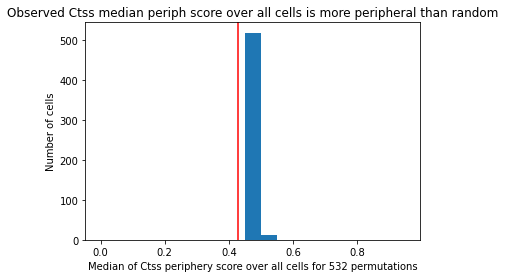

In [71]:
null_ctss_meds.plot.hist(bins = np.arange(0,1,0.05))
plt.axvline(true_ctss_over_cell_meds,color='red')
plt.title('Observed Ctss median periph score over all cells is more peripheral than random')
plt.xlabel('Median of Ctss periphery score over all cells for {} permutations'.format(null_ctss_meds.shape[0]))
plt.ylabel('Number of cells')
plt.show()
plt.close()

# Code that's still not fast enough that goes over all genes

pseudo code


For each permutation iteration do the following
* Permute the gene labels for each cell
* Within each cell, calculate the new normalized permuted periphery ranks
* Within each cell, and for each gene, calculate the median norm periph rank
* Over all permuted cells, calculate the median of the per cell median norm periph rank (median of median)
* Save the per-gene, per-permutation-iteration median-median result

The resulting data is then a table of size genes by permutation-iterations
The entries are the overall-cell median permuted normed periph rank

The output dataframe is not going to be that large, so I think I can instantiate it with zeros, and then fill it in

Want to avoid having explicit for-loops in favoring of vectorizing for speed

I think the difficult part will be permuting ranks for each cell in a vectorized way

In [8]:
df.groupby('cell_id').size()

cell_id
10000143038275111136124942858811168393     161
100007228202835962319771548915451072492     79
100013893144618144270850756017896167367    219
100017533667894826939857215877082515137     75
100018547319796564052034805202079258035     72
                                          ... 
99987465505639073211021560543065098772     549
99989592830367590092304100078674096866     184
99991756591196613545069880666241120777      27
99997421766159526763299676887100858104      80
99997470167777465101376150817407669505     809
Length: 237879, dtype: int64

In [65]:
#Just pull the first 10 cells for practice
sub_df = df[df['cell_id'].isin(df.drop_duplicates('cell_id').head(100)['cell_id'].values)]

In [70]:
import time
start = time.time()
def permutations(sub_df, its=100):
    def gene_perm_median_scores(sub_df):
        for cell_id,cell_g in sub_df.groupby('cell_id'):
            num_spots = cell_g.shape[0]
            cell_g['norm_ranks'] = np.random.permutation(np.arange(num_spots))/num_spots
            gene_medians = cell_g.groupby('target_molecule_name')['norm_ranks'].median()

            yield gene_medians.rename(cell_id)

    for i in range(its):
        single_perm_all_cells = pd.concat(gene_perm_scores(sub_df),axis=1)
        single_perm_medians = single_perm_all_cells.median(axis=1)
        yield single_perm_medians.rename(i)


x = pd.concat(permutations(df, its=1),axis=1)
print(time.time()-start)
x.head()

1151.476449251175


,0
Adra1b,0.497959
Aqp4,0.500000
Bcl11b,0.499329
Brinp3,0.497279
Cdh20,0.496883


5730522E02Rik    0.878127
Acta2            0.400000
Adam2            0.715962
Ano4             0.631321
B4galnt3         0.422596
                   ...   
Npas1            0.538017
Nr2f2            0.435443
Prox1            0.831646
Rnf152           0.001266
Pxdc1            0.360927
Length: 220, dtype: float64

In [28]:
sub_df.groupby(['cell_id']).apply(
    lambda cell_g: np.random.permutation(np.arange(g['num_cell_spots'].values[0]))
)

cell_id                                  target_molecule_name
217951229059897556843731256135790480948  5730522E02Rik           [328, 899, 1196, 331, 742, 466, 403, 1142, 162...
                                         Acta2                   [1233, 87, 686, 371, 1046, 288, 907, 776, 1158...
                                         Adam2                   [738, 334, 108, 99, 305, 1195, 799, 885, 592, ...
                                         Ano4                    [693, 1072, 951, 721, 43, 740, 576, 541, 776, ...
                                         B4galnt3                [369, 1252, 1083, 1051, 1248, 825, 196, 215, 4...
                                                                                       ...                        
88185404565464270717298543203439325454   Tmtc2                   [152, 61, 33, 22, 18, 1, 97, 120, 141, 77, 46,...
                                         Trp53i11                [110, 133, 129, 1, 157, 137, 106, 135, 87, 141...
                  